<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

# Let's save the image as pkl for later easy acces and reuse

In [ ]:
!pip install pytorch_lightning
!pip install torchmetrics
!pip install segmentation_models_pytorch
!pip install --upgrade timm
!pip install ttach
!pip install einops
!pip install rasterio

In [1]:
# Importing the needed libraries
import getpass
import glob
import os
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
from skimage.morphology import reconstruction
import cv2

from einops import rearrange

from pathlib import Path
from random import choice
from scipy.ndimage import gaussian_filter

In [2]:
dataset_id = 'nasa_rwanda_field_boundary_competition'
assets = ['labels']

In [3]:
#image snapshot dimensions
IMG_WIDTH = 256 
IMG_HEIGHT = 256 
IMG_CHANNELS = 4 #we have the rgba bands

We have two sets of data: the train and test dataset, each having a list of file ids belonging to them.
For model development purposes, we will use the training set(`train_tiles`) and use the test set for model prediction/evaluation.

In [4]:
train_source_items = f"{dataset_id}/{dataset_id}_source_train"
test_source_items = f"{dataset_id}/{dataset_id}_source_test"
train_label_items = f"{dataset_id}/{dataset_id}_labels_train"

In [5]:
def clean_string(s: str) -> str:
    """
    extract the tile id and timestamp from a source image folder
    e.g extract 'ID_YYYY_MM' from 'nasa_rwanda_field_boundary_competition_source_train_ID_YYYY_MM'
    """
    s = s.replace(f"{dataset_id}_source_", '').split('_')[1:]
    return '_'.join(s)

In [6]:
train_tiles = [clean_string(s) for s in next(os.walk(train_source_items))[1]]
train_tiles.sort()

In [7]:
test_tiles = [clean_string(s) for s in next(os.walk(test_source_items))[1]]
test_tiles.sort()

In [8]:
df_train = pd.DataFrame([t.split('_') for t in train_tiles], columns=['chip_id', 'year', 'month'])
df_test = pd.DataFrame([t.split('_') for t in test_tiles], columns=['chip_id', 'year', 'month'])

In [9]:
df_test.head(5)

,chip_id,year,month
0,00,2021,03
1,00,2021,04
2,00,2021,08
3,00,2021,10
4,00,2021,11


In [10]:
df_train.groupby('chip_id').nth(0).year.value_counts()

2021    57
Name: year, dtype: int64

In [11]:
df_test.groupby('chip_id').nth(0).year.value_counts()

2021    13
Name: year, dtype: int64

In [12]:
df_train.head()

,chip_id,year,month
0,00,2021,03
1,00,2021,04
2,00,2021,08
3,00,2021,10
4,00,2021,11


In [13]:
df_test.tail()

,chip_id,year,month
73,12,2021,04
74,12,2021,08
75,12,2021,10
76,12,2021,11
77,12,2021,12


In [15]:
#Helper functions for temporal saving
def load_inputs(chip_id, file_path_common):
    images = [
        rio.open(f"{file_path_common}_{chip_id}_2021_{month_code}/B{band}.tif").read(1)
        for month_code in ['03', '04', '08', '10', '11', '12'] for band in ['03', '02', '01', '04']
    ]
    images = np.stack(images, axis=-1) #.astype('float')

    return images

def load_label(chip_id):
    filepath = f"{train_label_items}/{dataset_id}_labels_train_{chip_id}/raster_labels.tif"
    label  = rio.open(filepath).read(1)
    return label

def create_extent(label):  # boundary used as input label here
    seed = np.copy(label)

    seed[1:-1, 1:-1] = label.max()

    filled = reconstruction(seed, label, method='erosion')

    extent = filled - label
    return extent


def get_distance(label):  # extent used as input label here
    tlabel = label.astype(np.uint8) 
    dist = cv2.distanceTransform(tlabel, 
                                 cv2.DIST_L2, 
                                 0)
    dist = cv2.normalize(dist, 
                         dist, 
                         0, 1.0, 
                         cv2.NORM_MINMAX)    
    return dist


def generate(chip_id, file_path_common):

    # read data
    image = load_inputs(chip_id, file_path_common)
    
    mask = None
    
    if 'train' in file_path_common:
        boundary = load_label(chip_id)
        extent = create_extent(boundary)

#         mask = np.stack([boundary, extent], axis=-1).astype('float')

        background = 1 - extent # 1 - mask.sum(axis=-1, keepdims=True)
        distance = get_distance(extent)
        mask = np.stack((boundary, extent, background, distance), axis=-1)

    return image, mask


def get_transform(
    field: np.ndarray,
    mask: np.ndarray,
    blur: int,
    flip: int,
    rotate: int,
):
    if blur:
        field, mask = t_blur(field, mask, sigma=3)
        
    field, mask = t_flip(field, mask, flip)
    field, mask = t_rotation(field, mask, rotate)
    
    return field, mask

In [16]:
from tqdm import tqdm

In [17]:
%%time
## saving training data
file_path_common=f"{train_source_items}/{dataset_id}_source_train"

write_folder = 'data/train'
os.makedirs(write_folder + '/' + 'fields/', exist_ok=True)
os.makedirs(write_folder + '/' + 'masks/', exist_ok=True)

for chip_id in tqdm(df_train.chip_id.unique()):
    image, mask = generate(chip_id, file_path_common)
    
    with open(write_folder +'/'+ f"fields/{chip_id}.pkl", 'wb') as handle:
        pickle.dump(image, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(write_folder +'/'+ f"masks/{chip_id}.pkl", 'wb') as handle:
        pickle.dump(mask, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|███████████████████████████████████████████| 57/57 [00:02<00:00, 25.96it/s]

CPU times: user 2.49 s, sys: 409 ms, total: 2.9 s
Wall time: 2.2 s


In [18]:
%%time
## saving test data
file_path_common=f"{test_source_items}/{dataset_id}_source_test"

write_folder = 'data/test'
os.makedirs(write_folder + '/' + 'fields/', exist_ok=True)

for chip_id in tqdm(df_test.chip_id.unique()):
    image, _ = generate(chip_id, file_path_common)
    
    with open(write_folder +'/'+ f"fields/{chip_id}.pkl", 'wb') as handle:
        pickle.dump(image, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 37.41it/s]

CPU times: user 327 ms, sys: 23.6 ms, total: 350 ms
Wall time: 349 ms


In [14]:
# save the sample dataframes
df_train.to_csv('data/train.csv', index=False)
df_test.to_csv('data/test.csv', index=False)


In [19]:
def load_file(filepath):
    if not os.path.exists(filepath):
        return None
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
        data = data.transpose(2,0,1).astype('float32')
    return data


def load_input(chip_id, file_path_common='data/train'):

    # read data
    image_path = f"{file_path_common}/fields/{chip_id}.pkl"
    image = load_file(image_path)

    mask_path = f"{file_path_common}/masks/{chip_id}.pkl"
    mask = load_file(mask_path)

    return image, mask

In [20]:
month_map = {
    '03': 'Mar', 
    '04': 'Apr', 
    '08': 'Aug', 
    '10': 'Oct', 
    '11': 'Nov', 
    '12': 'Dec',
}

In [21]:
def plot_chip0(chip_id, file_path_common = 'data/train'):
    cols = 4 + 3
    rows = 6 + 1
    figsize = (cols*4, rows*4)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
#     s2_titles = ['B04', 'B03', 'B02', 'B08']
    s2_titles = ['Red', 'Green', 'Blue', 'NIR']
    ndvi_titles = ['NDV-R', 'NDV-G', 'NDV-B']
    mask_titles = ['boundary', 'extent', 'background', 'distance']
    
    images, mask = load_input(chip_id)
    
    for row, (month_code, month_name) in enumerate(month_map.items()):
        col = 0
        image = images[4*row:4*(row+1)]
        ndvi = (image[3:4] - image[:3]) / (image[3:4] + image[:3])
        for b_id in range(4):
            axes[row, col].imshow(image[b_id])
            if row == 0:
                axes[row, col].set_title(s2_titles[b_id])
            if col == 0:
                axes[row, col].set_ylabel(month_name)
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])
            col += 1
          
        for n_id in range(3):
            axes[row, col].imshow(ndvi[n_id])
            if row == 0:
                axes[row, col].set_title(ndvi_titles[n_id])
#             if col == 0:
#                 axes[row, col].set_ylabel(month_name)
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])
            col += 1
        
    
    if mask is None:
        mask = np.ones((4, 256, 256))
    
    col = 0
    for m_id in range(4):
        axes[6, col].imshow(mask[m_id])
        axes[6, col].set_title(mask_titles[m_id])
        axes[6, col].axis('off')
        col += 1
    plt.show()

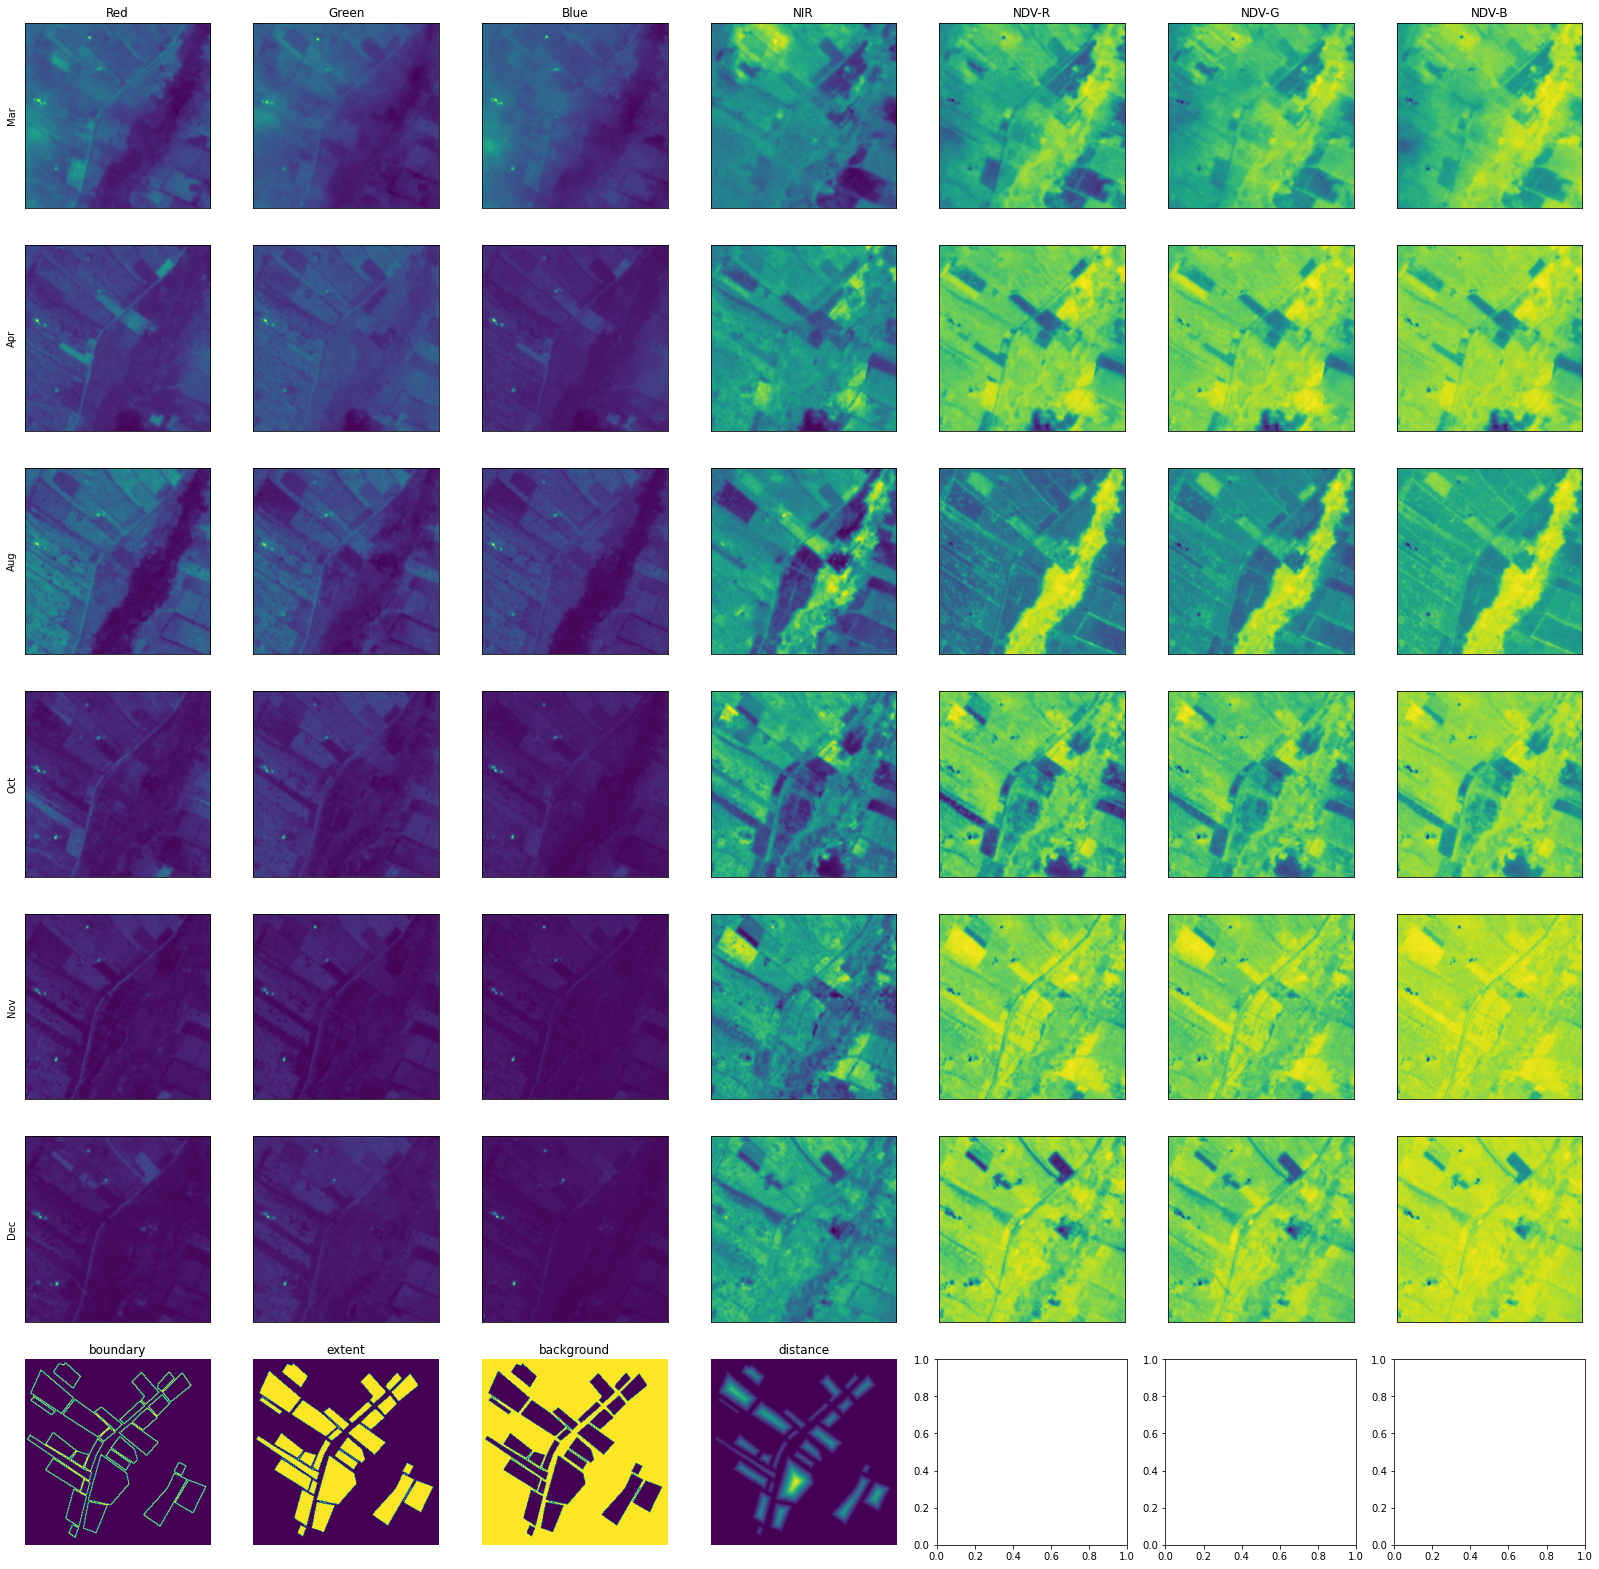

In [22]:
plot_chip0('00')

In [23]:
def plot_chip(chip_id, file_path_common = 'data1/train'):
    cols = 6 + 1
    rows = 4 + 3
    figsize = (cols*4, rows*4)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
#     s2_titles = ['B04', 'B03', 'B02', 'B08']
    s2_titles = ['Red', 'Green', 'Blue', 'NIR']
    ndvi_titles = ['NDV-R', 'NDV-G', 'NDV-B']
    mask_titles = ['boundary', 'extent', 'background', 'distance']
    
    images, mask = load_input(chip_id)
    
    for col, (month_code, month_name) in enumerate(month_map.items()):
        row = 0
        image = images[4*row:4*(row+1)]
        ndvi = (image[3:4] - image[:3]) / (image[3:4] + image[:3])
        
        for b_id in range(4):
#             image = rio.open(f"{file_path_common}_{chip_id}_2021_{month_code}/B{band}.tif").read(1)
#             axes[row, col].imshow(image)
            axes[row, col].imshow(image[b_id])
            if col == 0:
                axes[row, col].set_ylabel(f"{s2_titles[b_id]}" )
            if row == 0:
                axes[row, col].set_title(month_name)
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])
            row += 1
        
        for n_id in range(3):
            axes[row, col].imshow(ndvi[n_id])
            if col == 0:
                axes[row, col].set_ylabel(ndvi_titles[n_id])
#             if col == 0:
#                 axes[row, col].set_ylabel(month_name)
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])
            row += 1
        
    if mask is None:
        mask = np.ones((4, 256, 256))
    
    row = 0
    for m_id in range(4):
        axes[row, 6].imshow(mask[m_id])
        axes[row, 6].set_title(mask_titles[m_id])
        axes[row, 6].axis('off')
        row += 1
    plt.show()

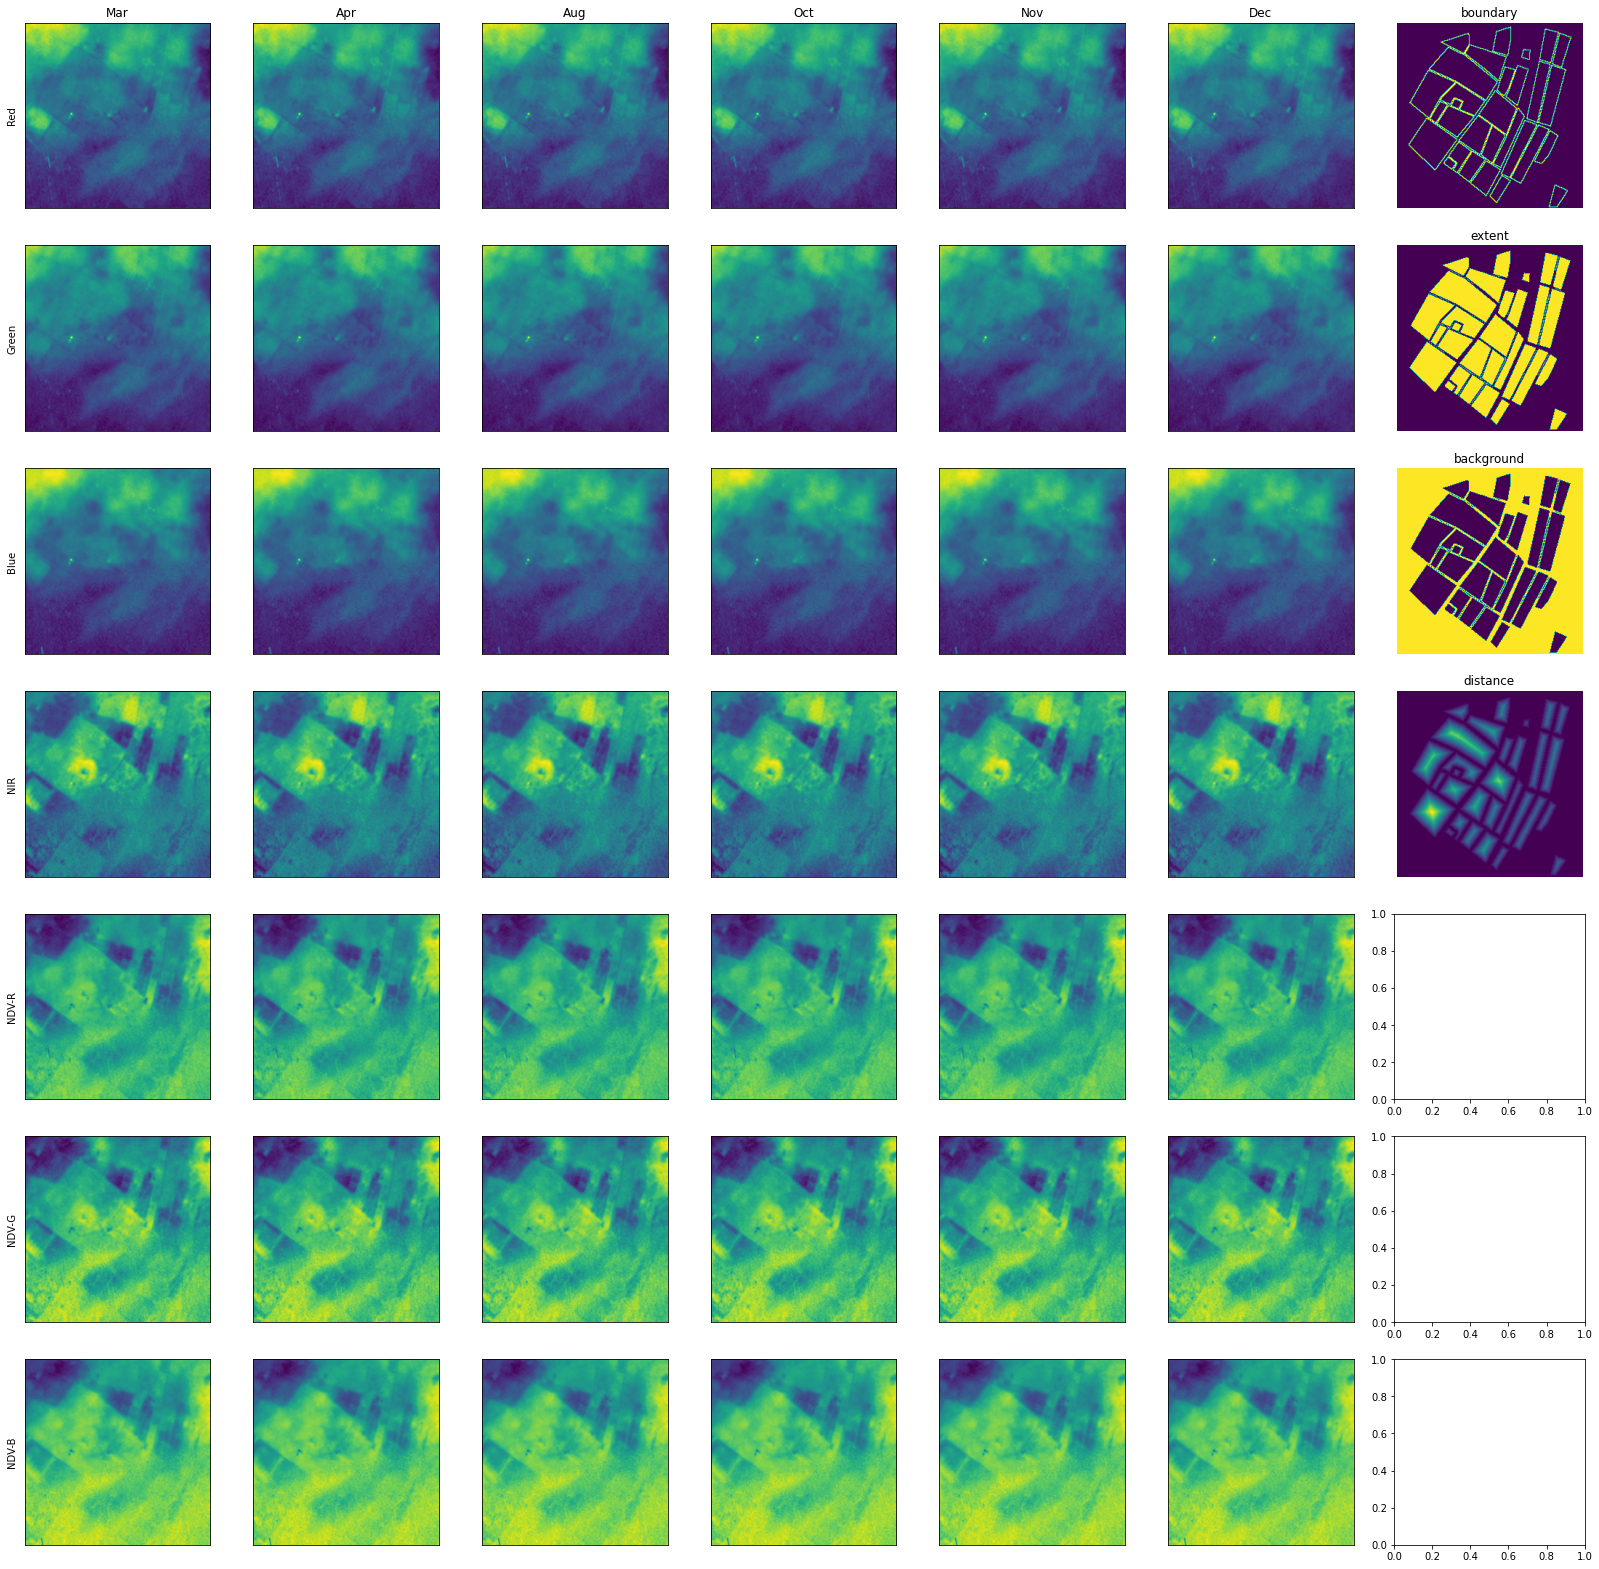

In [24]:
plot_chip('07')

In [25]:
# get statistics

images = []
for i in range(57):
    image, _ = load_input(f"{i:02d}")
    images.append(image)

images = np.stack(images, axis=0)

im_mean = images.mean(axis=(0,2,3))
im_std = images.std(axis=(0,2,3))

In [26]:
im_mean

array([ 863.2518 ,  865.2677 ,  529.2505 , 3078.7212 ,  949.2359 ,
        907.6048 ,  584.78613, 3043.1943 ,  989.06464,  825.8412 ,
        478.29688, 2869.0164 ,  895.6183 ,  818.5562 ,  463.68314,
       3042.7363 ,  806.8484 ,  795.07745,  445.39203, 3143.7144 ,
        808.9763 ,  791.50116,  430.56223, 3131.7039 ], dtype=float32)

In [27]:
im_std

array([182.47865 , 154.65396 , 168.338   , 422.41266 , 232.08676 ,
       210.54506 , 229.9699  , 476.7492  , 239.36769 , 109.9667  ,
        81.161674, 429.01984 , 199.07053 ,  97.33629 ,  70.4519  ,
       581.4538  , 152.47546 ,  89.07032 ,  67.22744 , 549.4979  ,
       134.65048 ,  98.62606 ,  67.80826 , 556.4275  ], dtype=float32)

In [28]:
df = pd.DataFrame(np.stack([im_mean, im_std], axis=0))
df.index = ['im_mean', 'im_std']
df.columns = [f"m{m}_b{b}" for m in ['03', '04', '08', '10', '11', '12'] for b in ['04','03','02', '08']]
df

,m03_b04,m03_b03,m03_b02,m03_b08,m04_b04,m04_b03,m04_b02,m04_b08,m08_b04,m08_b03,...,m10_b02,m10_b08,m11_b04,m11_b03,m11_b02,m11_b08,m12_b04,m12_b03,m12_b02,m12_b08
im_mean,863.251770,865.267700,529.250488,3078.721191,949.235901,907.604797,584.786133,3043.194336,989.064636,825.841187,...,463.683136,3042.736328,806.848389,795.077454,445.392029,3143.714355,808.976318,791.50116,430.562225,3131.703857
im_std,182.478653,154.653961,168.337997,422.412659,232.086761,210.545059,229.969894,476.749207,239.367691,109.966698,...,70.451897,581.453796,152.475464,89.070320,67.227440,549.497925,134.650482,98.62606,67.808258,556.427490


In [29]:
df.to_csv('data/statistics.csv')